Импортируем необходимые библиотеки и данные

In [372]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [373]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

In [374]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

Посмотрим на данные

In [375]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [376]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [377]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [378]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Сохраняем 'Survived' и 'PassengerId' отдельно

In [379]:
survived = train_data['Survived']
train_data.drop(columns=['Survived'], inplace=True)

Заполним пропуски в данных

In [380]:
for dataset in [train_data, test_data]:
    dataset['Age'] = dataset['Age'].fillna(train_data['Age'].median())
    dataset['Embarked'] = dataset['Embarked'].fillna('None')
    dataset['Fare'] = dataset['Fare'].fillna(test_data['Fare'].median())
    dataset['Family'] = dataset['SibSp'] + dataset['Parch']
    dataset.drop(['SibSp', 'Parch', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

<Axes: xlabel='Family', ylabel='count'>

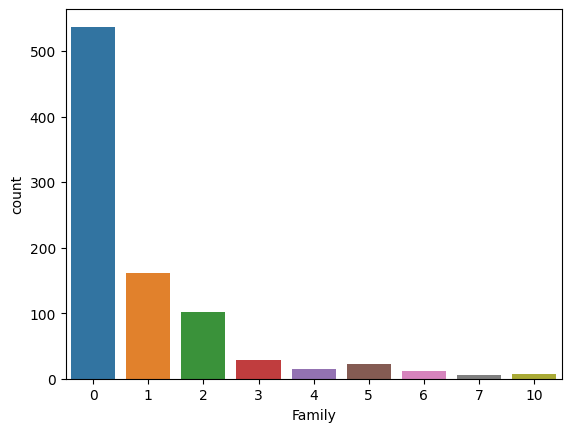

In [381]:
sns.countplot(data=train_data, x='Family')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

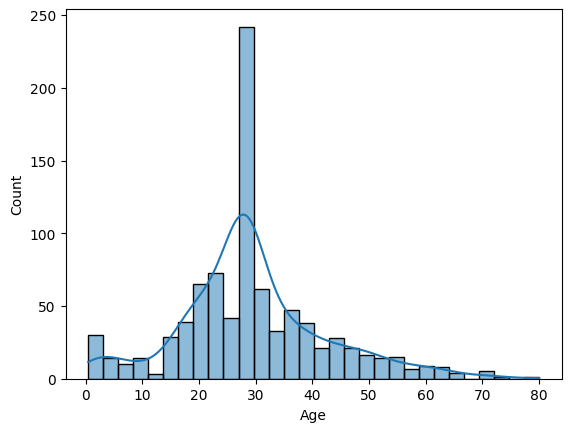

In [382]:
sns.histplot(train_data['Age'], kde=True)

Объединяем train и test для одинаковых категориальных признаков

In [383]:
combined = pd.concat([train_data, test_data], axis=0)

Преобразование категориальных данных

In [384]:
gender_columns = pd.get_dummies(combined['Sex'], prefix='Sex')
embarked_columns = pd.get_dummies(combined['Embarked'], prefix='Embarked')

In [385]:
combined.drop(['Sex', 'Embarked'], axis=1, inplace=True)
combined = pd.concat([combined, gender_columns, embarked_columns], axis=1)

Преобразование числовых данных в категориальные

In [386]:
pclass_columns = pd.get_dummies(combined['Pclass'], prefix='Pclass')
combined.drop(['Pclass'], axis=1, inplace=True)
combined = pd.concat([combined, pclass_columns], axis=1)

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
labels = [f'Age_{i}' for i in range(len(bins)-1)]
combined['Categorized_age'] = pd.cut(combined['Age'], bins, labels=labels)
combined.drop(['Age'], axis=1, inplace=True)

age_columns = pd.get_dummies(combined['Categorized_age'], prefix='Categorized_age')
combined.drop(['Categorized_age'], axis=1, inplace=True)
combined = pd.concat([combined, age_columns], axis=1)

Разделяем обратно train и test

In [387]:
train_data = combined.iloc[:len(train_data)].copy()
test_data = combined.iloc[len(train_data):].copy()

Возвращаем 'Survived' в train_data

In [388]:
train_data['Survived'] = survived.values

In [389]:
train_data.head()

,PassengerId,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_None,Embarked_Q,Embarked_S,Pclass_1,...,Pclass_3,Categorized_age_Age_0,Categorized_age_Age_1,Categorized_age_Age_2,Categorized_age_Age_3,Categorized_age_Age_4,Categorized_age_Age_5,Categorized_age_Age_6,Categorized_age_Age_7,Survived
0,1,7.2500,1,False,True,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,0
1,2,71.2833,1,True,False,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,1
2,3,7.9250,0,True,False,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,1
3,4,53.1000,1,True,False,False,False,False,True,True,...,False,False,False,False,True,False,False,False,False,1
4,5,8.0500,0,False,True,False,False,False,True,False,...,True,False,False,False,True,False,False,False,False,0


Обучим модели

In [390]:
X = train_data.drop(['Survived', 'PassengerId'], axis=1)
y = train_data['Survived']
test_features = test_data.drop(['PassengerId'], axis=1)

In [391]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(C=0.01, max_iter=1000),
    "Support Vector Classifier": SVC(C=1, kernel='linear'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=20),
    "AdaBoost": AdaBoostClassifier(learning_rate=0.01, n_estimators=300),
    "Random Forest": RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=300),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200)
}

Оценим модели

In [392]:
from sklearn.model_selection import cross_val_score
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{name} - Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    model.fit(X, y)

Logistic Regression - Accuracy: 0.7666 (+/- 0.0296)
Support Vector Classifier - Accuracy: 0.7935 (+/- 0.0141)
Decision Tree - Accuracy: 0.8182 (+/- 0.0162)
AdaBoost - Accuracy: 0.7912 (+/- 0.0234)
Random Forest - Accuracy: 0.8126 (+/- 0.0083)
Gradient Boosting - Accuracy: 0.8193 (+/- 0.0177)


In [393]:
'''
from sklearn.model_selection import GridSearchCV

# Гиперпараметры для каждой модели
param_grids = {
    "Logistic Regression": {
        "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    },
    "Support Vector Classifier": {
        "C": [0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"]
    },
    "Decision Tree": {
        "max_depth": [5, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10, 20]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200, 300, 400, 500],
        "learning_rate": [0.001, 0.01, 0.1, 0.5, 1]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300, 400, 500],
        "max_depth": [5, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200, 300, 400, 500],
        "learning_rate": [0.001, 0.01, 0.1, 0.5, 1],
        "max_depth": [3, 5, 10, 20, 30]
    }
}

# Оптимизация моделей
best_models = {}
for name, model in models.items():
    print(f"Оптимизируем {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X, y)
    best_models[name] = grid_search.best_estimator_
    print(f"Лучшие параметры для {name}: {grid_search.best_params_}")
'''

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Гиперпараметры для каждой модели\nparam_grids = {\n    "Logistic Regression": {\n        "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]\n    },\n    "Support Vector Classifier": {\n        "C": [0.01, 0.1, 1, 10, 100],\n        "kernel": ["linear", "poly", "rbf", "sigmoid"]\n    },\n    "Decision Tree": {\n        "max_depth": [5, 10, 20, 30, 40, 50],\n        "min_samples_split": [2, 5, 10, 20]\n    },\n    "AdaBoost": {\n        "n_estimators": [50, 100, 200, 300, 400, 500],\n        "learning_rate": [0.001, 0.01, 0.1, 0.5, 1]\n    },\n    "Random Forest": {\n        "n_estimators": [50, 100, 200, 300, 400, 500],\n        "max_depth": [5, 10, 20, 30, 40, 50],\n        "min_samples_split": [2, 5, 10, 20],\n        "min_samples_leaf": [1, 2, 5, 10]\n    },\n    "Gradient Boosting": {\n        "n_estimators": [50, 100, 200, 300, 400, 500],\n        "learning_rate": [0.001, 0.01, 0.1, 0.5, 1],\n        "max_depth": [3, 5, 10, 20, 30]\

Достоверность - соотношение между количеством правильно помеченных точек и их общим количеством.

ПОЛНОТА — доля правильно классифицированных точек с положительными метками. Другими словами, Recall = TP/(TP + FN), где TP — количество истинно положительных результатов, FN — количество ложноотрицательных результатов.

ТОЧНОСТЬ — доля правильно классифицированных точек среди тех, что классифицированы как положительные. Другими словами, точность = TP/(TP + FP), где FP — количество ложноположительных результатов.

F1-МЕРА — среднее гармоническое значение точности и полноты. Это число находится между точностью и полнотой, но ближе к меньшему из двух.

Сделаем submission

In [395]:
predictions = models["Gradient Boosting"].predict(test_features)

# Создание submission файла
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": predictions
})
submission.to_csv("submission.csv", index=False)
